In [1]:
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.25)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

## MSM of a bistable model potential
Here we analyze a Brownian dynamics trajectory on the model potential by Berezhkovskii et al ([*J. Chem. Phys.*, 2014](https://doi.org/10.1063/1.4902243)), used in the context of single molecule force spectroscopy by Cossio, Hummer and Szabo ([*PNAS*, 2015](https://doi.org/10.1073/pnas.1519633112)).

### Analysis

First of all, we import the [PyEMMA](www.emma-project.org) software package.

In [2]:
import pyemma
pyemma.__version__

'2.5.7'

Next we load a trajectory run on the bistable potential and check for the shape of the trajectory. You can download the trajectory file from [here](https://osf.io/2ujtg/?view_only=11824fcadefa4987bfb5a5dd64b6ad6f).

In [3]:
h5file = "./data/cossio_kl1.3_Dx1_Dq1.h5"
f = h5py.File(h5file, 'r')
data0 = np.array(f['data'])
f.close()
X = data0[:,[1,2]]

In [4]:
X0, X1 = X[:,0], X[:,1]
X.shape, X0.shape, X1.shape

((25001, 2), (25001,), (25001,))

In [5]:
from pyemma.util.contexts import settings
import pyemma.coordinates as coor
import pyemma.plots as mplt

Check $x$ and $y$ coordinates along the trajectory. We see that as we would expect for this model both coordinates are highly correlated.

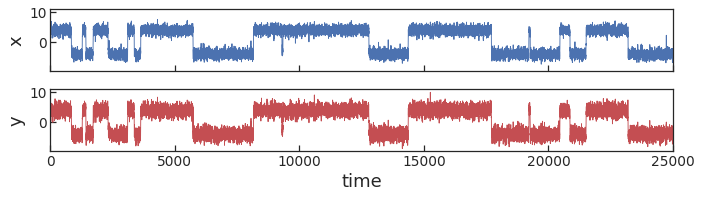

In [6]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10, 3.))
ax[0].plot(range(len(X[:,0])), X[:,0], linewidth=0.9, c='b')
ax[1].plot(range(len(X[:,1])), X[:,1], linewidth=0.9, c='r')
ax[1].set_xlabel('time', fontsize=18)
ax[0].set_ylabel('x', fontsize=18)
ax[1].set_ylabel('y', fontsize=18)
ax[0].set_xlim(0, 25000)
plt.tight_layout()
#plt.savefig('../figures/cossio/traj_1d.png', dpi=300, transparent=True)

Then we load the trajectory into PyEMMA.

In [7]:
inp = coor.source([data0[:,[1,2]]])

In [8]:
print ('number of trajectories = ', inp.ntraj)
print('1st trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

number of trajectories =  1
1st trajectory length =  25001
number of dimension =  2


### Traditional MSM construction
In this case, for producing the standard MSM we will run k-means clustering of the dataset. Alternatively, datapoints could be assigned to states using a grid.

In [9]:
cl = coor.cluster_kmeans(data=[X], k=100, max_iter=150) #, stride=1
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
ccx = cl.clustercenters[:,0]
ccy = cl.clustercenters[:,1]

For visualization purposes, we generate the free energy surface described by Berezhkovskii et al. and plot together with the cluster centers resulting from K-means clustering. For this we will need a separate bit of Cython code available at [Github](https://github.com/daviddesancho/smFSmodels), although the necessary cossio.so file is available [here](https://osf.io/2ujtg/?view_only=11824fcadefa4987bfb5a5dd64b6ad6f).

In [10]:
import cossio

In [11]:
yp = np.linspace(-10.,10.,400)
xp = np.linspace(-10.,10.,400)
mat = np.zeros((len(xp), len(yp)))
for i, x_i in enumerate(xp):
    for j, y_i in enumerate(yp):
        aux = cossio.Gqx(x_i,y_i, kl=1.3)
        mat[i, j] = aux
Xpp, Ypp = np.meshgrid(xp,yp)

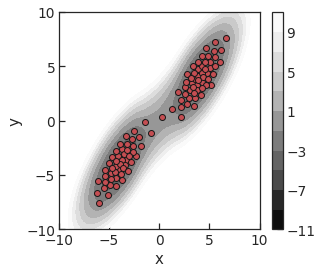

In [12]:
fig, ax = plt.subplots(figsize=(4.5,4))
lev = np.arange(-11,13, 2)
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r')
ax.plot(ccx, ccy, linewidth=0, marker='o', mfc='r', mec='k')
#im = ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
#           cmap='viridis', alpha=0.5);
plt.colorbar(CS)
ax.set_xlabel('x')
ax.set_ylabel('y')
yt = np.arange(-10,10,5)
ax.set_yticks([-10,-5,0,5,10])

Construct the MSM corresponding to the aforementioned discretization.

In [13]:
import pyemma.msm as msm
import pyemma.plots as mplt
lags = [1, 2, 5, 10, 20, 30]

its = msm.its(dtrajs, lags=lags, errors='bayes')

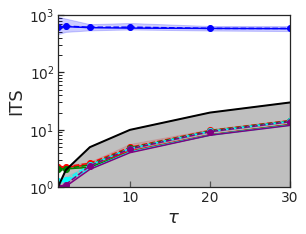

In [14]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
mplt.plot_implied_timescales(its, ylog=True, nits=5)
ax.set_ylim(1,1000)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('ITS', fontsize=18)
plt.tight_layout()

In [15]:
M = msm.estimate_markov_model(dtrajs, 10)

In [16]:
M.timescales()[:2]

array([591.88019351,   4.26907994])

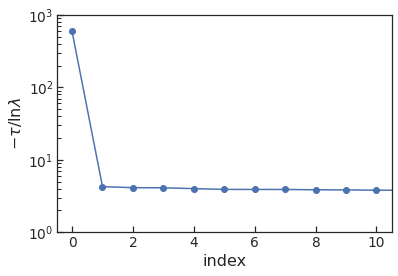

In [17]:
fig, ax = plt.subplots()
ax.plot(M.timescales(),linewidth=1.5, marker='o')
ax.set_xlabel(r'index', fontsize=16)
ax.set_ylabel(r'$-\tau/\ln \lambda$', fontsize=16)
ax.set_xlim(-0.5,10.5)
ax.set_ylim(1,1000)
plt.yscale('log')

In [18]:
eigvec = M.eigenvectors_left()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

first eigenvector is one: False (min=-0.031011077471173987, max=0.03280210274670518)


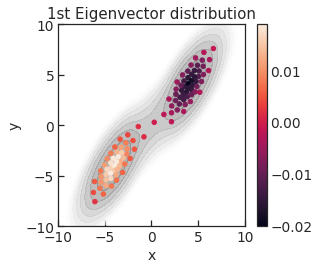

In [19]:
fig, ax = plt.subplots(figsize=(4.65, 4))
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.5)
sc = ax.scatter(cl.clustercenters[:,0], cl.clustercenters[:,1], c=eigvec[1], s=20)
plt.colorbar(sc)
ax.set_title('1st Eigenvector distribution')
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.tight_layout()

Since there is a single slow process, let us lump the microstates into two macrostates by using PCCA+ spectral clustering.

In [20]:
pcca = M.pcca(2)

In [21]:
pcca_sets = M.metastable_sets

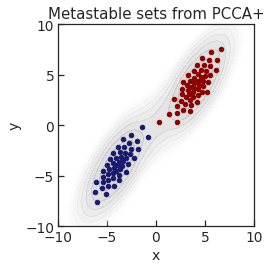

In [22]:
fig, ax = plt.subplots(figsize=(4., 4))
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.25)
ax.set_title('Metastable sets from PCCA+')
ax.scatter(cl.clustercenters[pcca_sets[0],0], cl.clustercenters[pcca_sets[0],1], color='midnightblue', s=20)
ax.scatter(cl.clustercenters[pcca_sets[1],0], cl.clustercenters[pcca_sets[1],1], color='darkred', s=20)
#im = ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
#           cmap='viridis', alpha=0.5);
#plt.colorbar(CS)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.tight_layout()

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


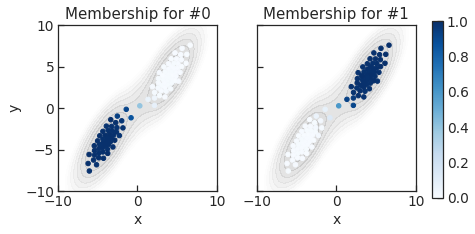

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(6.25, 3.5), sharex=True, sharey=True)
CS = ax[0].contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.25)
CS = ax[1].contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.25)
ax[0].set_title('Membership for #0')
ax[1].set_title('Membership for #1')
im = ax[0].scatter(cl.clustercenters[:,0], cl.clustercenters[:,1], \
                   c=pcca.memberships[:,0], s=20, cmap='Blues')
im = ax[1].scatter(cl.clustercenters[:,0], cl.clustercenters[:,1], \
                   c=pcca.memberships[:,1], s=20, cmap='Blues')
ax[0].set_xlabel('x', fontsize=14)
ax[0].set_ylabel('y', fontsize=14)
ax[1].set_xlabel('x', fontsize=14)
cbar_ax = fig.add_axes([0.98, 0.18, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout()
sns.set_context('paper', font_scale=1.7)

In [24]:
A = [i for i, x in enumerate(eigvec[1]) if (x>0.015)] 
B = [i for i, x in enumerate(eigvec[1]) if (x<-0.015)] 
flux = pyemma.msm.tpt(M, A, B)

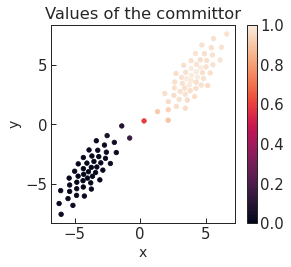

In [25]:
fig, ax = plt.subplots(figsize=(4.5, 4))
ax.set_title('Values of the committor')
sc = ax.scatter(cl.clustercenters[:,0], cl.clustercenters[:,1], c=flux.committor, s=20)
plt.colorbar(sc)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.tight_layout()

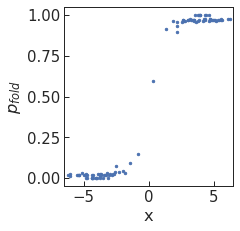

In [26]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax.plot(cl.clustercenters[:,0], flux.committor, '.')
ax.set_xlim(-6.5,6.5)
ax.set_xlabel('x')
ax.set_ylabel(r'$p_{fold}$')
plt.tight_layout()

Chapman-Kolmogorov test for the MSM resulting from PCCA+ clustering.

In [27]:
M = msm.bayesian_markov_model(dtrajs, 10)

In [28]:
ck = M.cktest(2) #M.cktest(3)

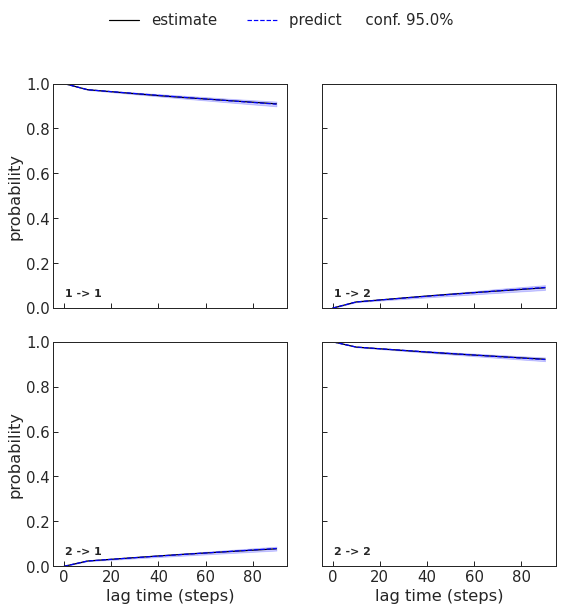

In [29]:
plt.rcParams.update({'font.size': 11})
fig, axes = mplt.plot_cktest(ck, figsize=(9, 9), \
                             padding_between=0.15, padding_top=0.13)

### MSM construction exploting density-based clustering

In [30]:
import hdbscan

In [31]:
data = np.vstack((X))

In [32]:
np.shape(data)

(25001, 2)

Apply HDBSCAN clustering with 'minimum cluster size' equal to 50 and 'minimum samples' equal to 70 to previously normalized data. Then look into resulting clusters.

In [33]:
from sklearn.preprocessing import StandardScaler
norm_X = StandardScaler().fit_transform(data)

In [34]:
hdb = hdbscan.HDBSCAN(min_cluster_size=100).fit(norm_X)

In [35]:
np.unique(hdb.labels_)

array([-1,  0,  1])

-1 cluster label denotes 'noise', so two clusters are obtained from HDBSCAN clustering. The latter can be better understood from the corresponding condensed tree plot. For more details see https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

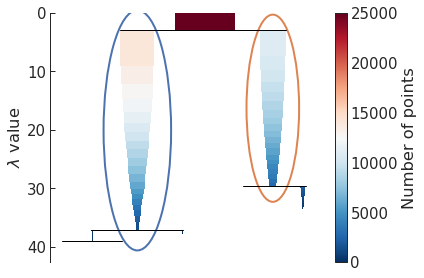

In [36]:
fig = plt.figure()
ax = hdb.condensed_tree_.plot(select_clusters=True, cmap='RdBu_r', selection_palette=sns.color_palette())
plt.tight_layout()

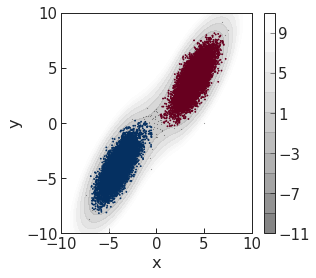

In [37]:
fig, ax = plt.subplots(figsize=(4.5, 4))
assign = hdb.labels_ >= 0
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.5)
ax.scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(data[nassign,0],data[nassign,1], marker='.', 
                s=0.5, c='k', alpha=0.5)
plt.colorbar(CS)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()

In order to be more stringent with the TBA methodology, let us set as 'noise' those points whose probability to be in their corresponding clusters is less than 40%.

In [38]:
for i, x_i in enumerate(hdb.labels_):
    if hdb.probabilities_[i] < 0.4:
        hdb.labels_[i] = -1
assign = hdb.labels_>= 0
nassign = hdb.labels_ < 0

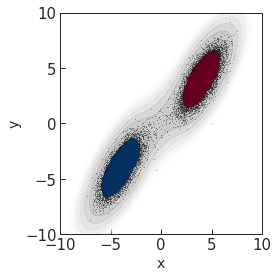

In [39]:
fig, ax = plt.subplots(figsize=(4.,4))
# histogram data
CS = ax.contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.5)

assign = hdb.labels_ >= 0
ax.scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(data[nassign,0],data[nassign,1], marker='.', 
                cmap='k', s=0.1, c='k')
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.tight_layout()

If we consider clusterization good enough, proceed to lag time selection and MSM estimation

In [40]:
import pyemma.msm as msm
import pyemma.plots as mplt
lags = [1, 2, 5, 10, 20, 30]

In [41]:
labels_tba = []
for i, l in enumerate(hdb.labels_):
    if l == -1:
        try:
            labels_tba.append(labels_tba[-1])
        except IndexError:
            pass
    else:
        labels_tba.append(l)

In [42]:
its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')

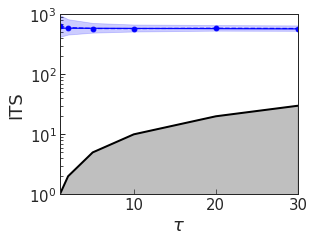

In [43]:
fig, ax = plt.subplots(figsize=(4.5,3.5))
mplt.plot_implied_timescales(its_hdb, ylog=True)
ax.set_ylim(1,1000)
ax.set_xlabel(r'$\tau$', fontsize=18)
ax.set_ylabel('ITS', fontsize=18)
plt.tight_layout()

In [44]:
M_hdb = msm.estimate_markov_model(labels_tba, 10)

In [45]:
M_hdb.timescales()

array([584.33007253])

Validate the obtained HDBSCAN MSM by carrying out the corresponding Chapman-Kolmogorov test.

In [46]:
M = msm.bayesian_markov_model(labels_tba, 10)

In [47]:
ck = M.cktest(2)

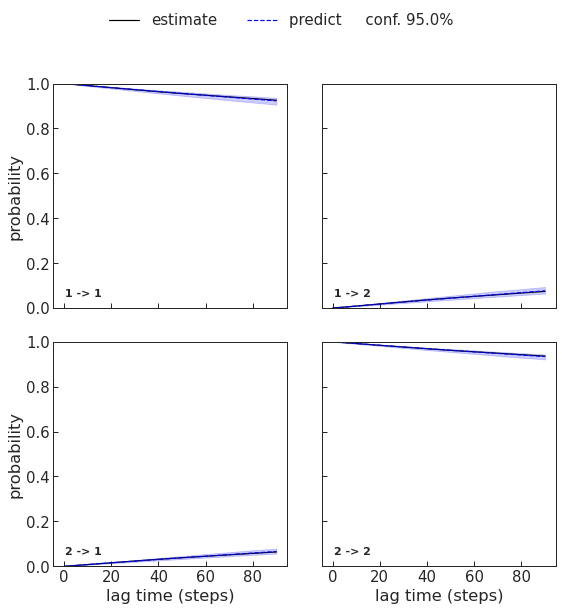

In [48]:
plt.rcParams.update({'font.size': 11})
fig, axes = mplt.plot_cktest(ck, figsize=(9, 9), \
                             padding_between=0.15, padding_top=0.13)

## Exploring parameter space

### Min cluster size

In [49]:
import hdbscan

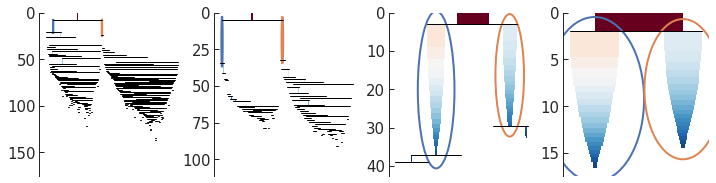

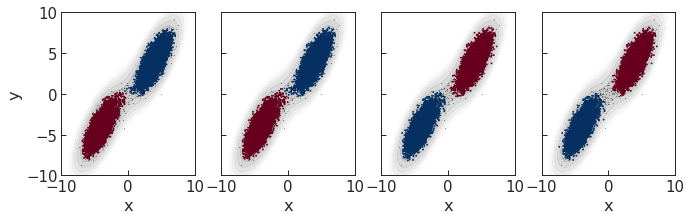

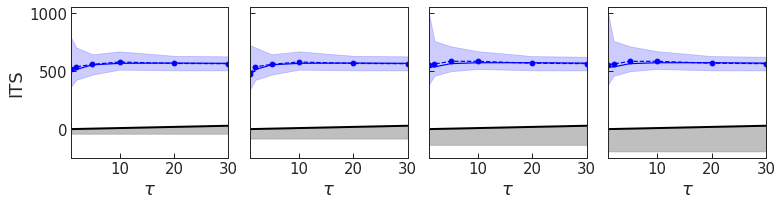

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
fig2, ax2 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)
fig3, ax3 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)

for i, mcs in enumerate([10, 20, 100, 500]):
    hdb = hdbscan.HDBSCAN(min_cluster_size=mcs).fit(norm_X)
    hdb.condensed_tree_.plot(select_clusters=True, cmap='RdBu_r', colorbar=False, \
                    axis=ax[i], selection_palette=sns.color_palette())
    ax[i].set_ylabel('')

    assign = hdb.labels_ >= 0
    CS = ax2[i].contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.5)
    ax2[i].scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb.labels_[assign])
    nassign = hdb.labels_ == -1
    ax2[i].scatter(data[nassign,0],data[nassign,1], marker='.', 
                s=0.5, c='k', alpha=0.5)

    ax2[i].set_xlabel('x')
    
    labels_tba = []
    for k, l in enumerate(hdb.labels_):
        if l == -1:
            try:
                labels_tba.append(labels_tba[-1])
            except IndexError:
                pass
        else:
            labels_tba.append(l)

    its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')
    
    mplt.plot_implied_timescales(its_hdb, ax=ax3[i], ylog=False)
    ax3[i].set_xlabel(r'$\tau$', fontsize=18)
    ax3[i].set_ylabel('')

ax2[0].set_ylabel('y')
plt.tight_layout()


ax3[0].set_ylabel('ITS', fontsize=18)
#ax3[0].set_ylim(1,1000)
plt.tight_layout()

### Soft clustering

In [51]:
hdb = hdbscan.HDBSCAN(min_cluster_size=100).fit(norm_X)
import copy

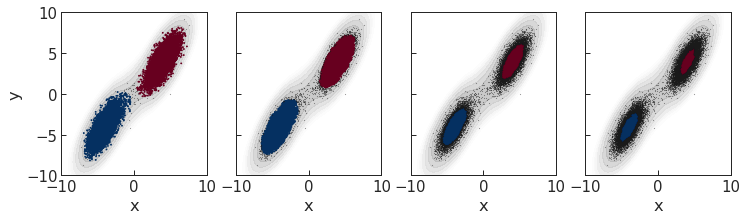

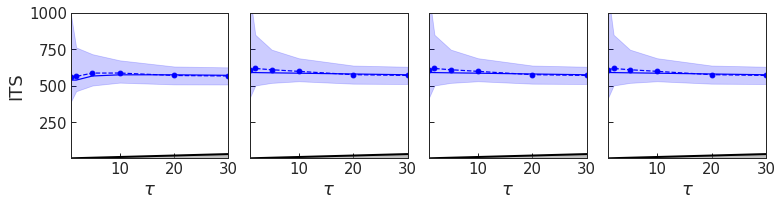

In [52]:
fig, ax = plt.subplots(1,4, figsize=(12, 3.), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(1,4, figsize=(11,3), sharex=True, sharey=True)

for j, pc in enumerate([0.0, 0.2, 0.5, 0.7]):
    hdb_copy = copy.deepcopy(hdb)
    for i, x_i in enumerate(hdb_copy.labels_):
        if hdb_copy.probabilities_[i] < pc:
            hdb_copy.labels_[i] = -1

    assign = hdb_copy.labels_ >= 0
    CS = ax[j].contourf(Xpp, Ypp, mat, levels=lev, cmap='Greys_r', alpha=0.5)
    ax[j].scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='RdBu', s=1, c=hdb_copy.labels_[assign])
    nassign = hdb_copy.labels_ == -1
    ax[j].scatter(data[nassign,0],data[nassign,1], marker='.', 
                s=0.5, c='k', alpha=0.5)

    ax[j].set_xlabel('x')
    
    
    labels_tba = []
    for i, l in enumerate(hdb_copy.labels_):
        if l == -1:
            try:
                labels_tba.append(labels_tba[-1])
            except IndexError:
                pass
        else:
            labels_tba.append(l)

    its_hdb = msm.its(labels_tba, lags=lags, errors='bayes')
    
    mplt.plot_implied_timescales(its_hdb, ax=ax2[j], ylog=False)
    ax2[j].set_xlabel(r'$\tau$', fontsize=18)
    ax2[j].set_ylabel('')
ax2[0].set_ylabel('ITS', fontsize=18)
ax2[0].set_ylim(1,1000)
plt.tight_layout()
    
ax[0].set_ylabel('y')
plt.tight_layout()

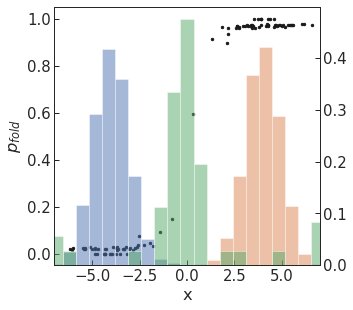

In [53]:
fig, ax = plt.subplots(figsize=(4.75,4.75))
axt = ax.twinx()
axt.hist(data[hdb.labels_==1, 0], bins=np.linspace(-10,10,30), density=True, alpha=0.5)
axt.hist(data[hdb.labels_==0, 0], bins=np.linspace(-10,10,30), density=True, alpha=0.5)
axt.hist(data[hdb.labels_==-1, 0], bins=np.linspace(-10,10,30), density=True, alpha=0.5)
ax.plot(cl.clustercenters[:,0], flux.committor, '.', color='k')
ax.set_xlim(-7, 7)
ax.set_xlabel('x')
ax.set_ylabel(r'$p_{fold}$')
sns.set_context('paper', font_scale=1.5)